# Objetivo.
El objetivo de este proyecto es analizar como ciertas conductas y variables pueden afectar al **rendimiento** de un estudiante. El conjunto de datos lo he sacado de [Kaggle](https://www.kaggle.com/datasets/nikhil7280/student-performance-multiple-linear-regression) y recoge la información de 10.000 alumnos. La variable **objetivo** es *performance index* que es un índice que nos indica el rendimiento de cada alumno. Los **features** o las variables que usaremos para predecir dicho índice son las siguientes:
- **Horas estudiadas**: horas totales estudiades por cada alumno
- **Notas previas**: La media de las notas obtenidas en exámenes previos
- **Actividades extracurriculares**: Si el alumno participa o no en actividades extracurriculares.
- **Horas de sueño**: la media de hora de sueño de cada alumno
- **Simulacros de examen**: número de simulacros de examen realizados 

### Primero: Importar librerías que usaremos.
Importaremos las librerías y paquetes que usaremos para analizar los datos.
- **Pandas**: librería por excelencia para analizar datos tabulares.
- **Matplotlib y seaborn**: librerías usadas para representar gráficos útiles.
- **Numpy**: librería que nos ayudará a hacer operaciones matemáticas y algebráicas de forma sencilla

Más adelante en el notebook usaremos más librerías que ya iremos importantdo

In [2]:
# Importar librerías.
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
# Cambio el estilo de los gráficos para obtener mejor experiencia
sns.set_style("whitegrid")

### Segundo: guardar datos en df y ver missings y duplicates.
Vamos a guardar el conjunto de datos en la variable `df` y vamos a analizar si hay valores faltantes o *missings* y también si hay filas *duplicadas*. 
- No vamos a encontrar *missing* values.
- Vamos a ver que hay 127 filas duplicadas, sin embargo, teniendo en cuenta que el conjunto de datos tiene información de $10000$ alumnos, creo que es factible que se den duplicados en este escenario. En caso de que consideres que es mejor eliminar estas filas puedes usar el método `drop_duplicates()` de pandas.

A parte de todo esto también voy a cambiar el nombre a las columnas de nuestro `df` por otros que no tengan espacios y sean más cortos.

In [3]:
df = pd.read_csv("Student_Performance.csv")
print(f"El df tiene {df.shape[0]} filas y {df.shape[1]} columnas")
df.head()

El df tiene 10000 filas y 6 columnas


,Hours Studied,Previous Scores,Extracurricular Activities,Sleep Hours,Sample Question Papers Practiced,Performance Index
0,7,99,Yes,9,1,91.0
1,4,82,No,4,2,65.0
2,8,51,Yes,7,2,45.0
3,5,52,Yes,5,2,36.0
4,7,75,No,8,5,66.0


In [4]:
# No hay missing data en nuestro df.
null_values = df.isnull().sum().sum()
print(f"Hay {null_values} valores nulos")

# Si que hay duplicados, pero no los voy a eliminar.
duplicados = df.duplicated().sum()
print(f"Hay {duplicados} filas duplicadas.")

Hay 0 valores nulos
Hay 127 filas duplicadas.


¡Hay 127 filas duplicadas! A pesar de que son bastantes no las voy a eliminar. Debemos tener en cuenta que el conjunto de datos tiene información de $10000$ alumnos, por tanto, es probable que se den casos de *duplicados*.

In [5]:
# Cambimos el nombre de las columnas con rename
df = df.rename(columns={
    "Hours Studied": "Horas_estudio",
    "Previous Scores": "Notas_previas",
    "Extracurricular Activities": "Act_extra",
    "Sleep Hours": "Horas_sueño",
    "Sample Question Papers Practiced": "Simulacros_examen",
    "Performance Index": "Rendimiento"
})

# Vemos las 5 primeros filas de nuestro df.
df.head()

,Horas_estudio,Notas_previas,Act_extra,Horas_sueño,Simulacros_examen,Rendimiento
0,7,99,Yes,9,1,91.0
1,4,82,No,4,2,65.0
2,8,51,Yes,7,2,45.0
3,5,52,Yes,5,2,36.0
4,7,75,No,8,5,66.0


Actividades extracurriculares es nuestra única columna no numérica. Podemos aplicar *one-hot encoding* y así sustituir los Yes por un 1 y los No por un 0

In [6]:
df["Act_extra"] = df["Act_extra"].apply(lambda value: 1 if value=="Yes" else 0)
df.head()

,Horas_estudio,Notas_previas,Act_extra,Horas_sueño,Simulacros_examen,Rendimiento
0,7,99,1,9,1,91.0
1,4,82,0,4,2,65.0
2,8,51,1,7,2,45.0
3,5,52,1,5,2,36.0
4,7,75,0,8,5,66.0


### Tercero: crear una columna categórica con el rendimiento.
Nuestra variable *target* es numérica y nos indica el índice de **rendimiento** obtenido por los alumnos. Vamos a explorar más a fondo esta variable creando otra columna que divida a los alumnos en las siguientes categorías:
1. *90<x<=100*: alumnos con un rendimiento entre 90 y 100
2. *70<x<=90*: alumnos con un rendimiento entre 70 y 90
3. *50<=x<=70*: alumnos con un rendimiento entre 50 y 70
4. *x<50*: alumnos con un rendimiento inferior a 50

De esta forma podremos ver cuales son las características que definen a los diferentes grupos formados.

In [7]:
# Tomamos una copia de la columna rendimiento.
new_performance_col = df["Rendimiento"].copy()

# Guardamos en una lista las diferentes querys
querys = ["90<Rendimiento<=100", "70<Rendimiento<=90", "50<=Rendimiento<=70", 
          "Rendimiento<50"]

# Loop sobre las querys
for query in querys:

    # Tomamos el índice en el que se cumple la query aplicamos sobre new_col
    index = df.query(query).index
    new_performance_col[index] = query.replace("Rendimiento", "x") 

# Guardamos la nueva columna y vemos los conteos de las categorías.
df["Categorias_Rend"] = new_performance_col
print("Número de alumnos en cada categoría:")
df["Categorias_Rend"].value_counts()

Número de alumnos en cada categoría:


x<50         4091
50<=x<=70    3404
70<x<=90     2296
90<x<=100     209
Name: Categorias_Rend, dtype: int64

Tener el número de alumnos de cada categoría ya nos da mucha información acerca de como se distribuyen las notas de **rendimiento**, sin embargo, es mucho más informativo saber el porcentaje de alumnos de cada una de las categorías:

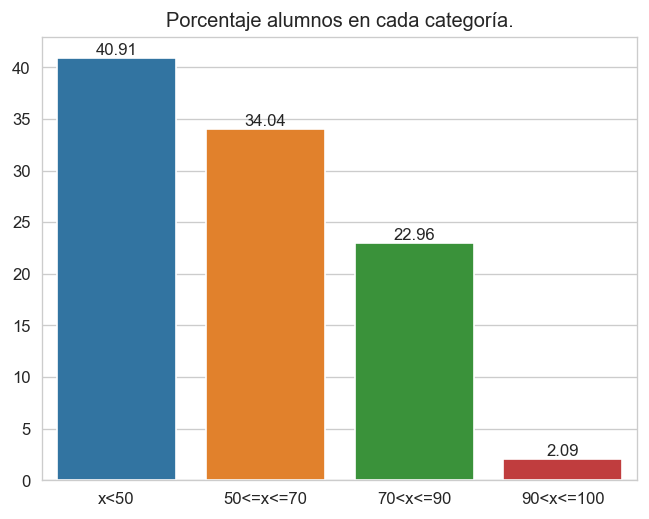

In [8]:
# Tomamos los porcentajes de cada categoría.
porcentajes = df["Categorias_Rend"].value_counts()/df.shape[0] * 100

# Representamos porcentajes en un gráfico de barras.
plt.figure(dpi=120)
bar = sns.barplot(x=porcentajes.index, y=porcentajes.values)
bar.bar_label(bar.containers[0])
bar.set_title("Porcentaje alumnos en cada categoría.");

#### ¿Cómo son los alumnos de cada categoría?
Ahora es momento de estudiar como se distribuyen las variables numéricas que tenemos en nuestro conjunto de datos en función de las cuatro categorías de alumnos que hemos creado anteriormente. Esto se puede ver de forma sencilla creando un `boxplot` para cada variable numérica en función de cada categoría.

Los features numéricos de nuestro df son:
['Horas_estudio', 'Notas_previas', 'Horas_sueño', 'Simulacros_examen']


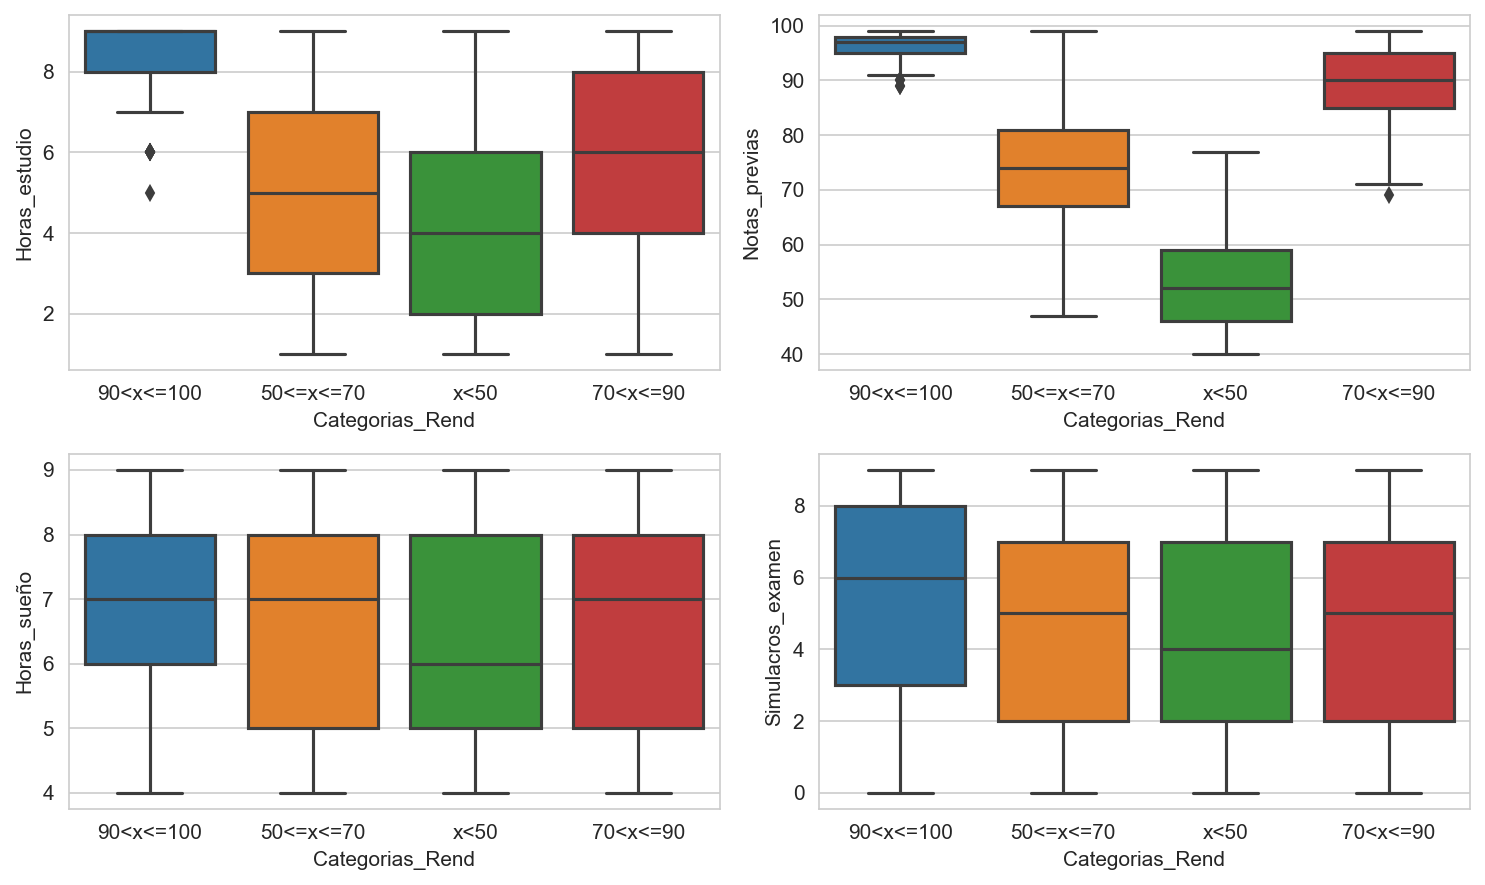

In [9]:
# num_feat = features numéricos
num_feats = df.columns.drop(["Categorias_Rend", "Rendimiento", "Act_extra"])
print(f"Los features numéricos de nuestro df son:\n{list(num_feats)}")

# Representamos boxplot de cada num_feat en función de cada categoría.
fig,axes = plt.subplots(ncols=2, nrows=2, figsize=(10, 6), dpi=150)

for index in range(len(num_feats)):
    feature = num_feats[index]
    ax = axes[0][index] if index<2 else axes[1][index - 2]
    sns.boxplot(x=df["Categorias_Rend"], y=df[feature], ax=ax)

plt.tight_layout()

Con este simple gráfico vemos que la categoría formada por los alumnos de mayor rendimiento (`90<x<=100`) se diferencian del resto sobre todo en las *notas previas* y en las *horas de estudio*. También observamos que los que menos duermen son los que peores notas han sacado y que hacer más simulacros de exámenes no parece tener un impacto muy elevado en el *rendimiento obtenido*.

Aquí tenemos las medias de cada categoría en cada feature numérico.


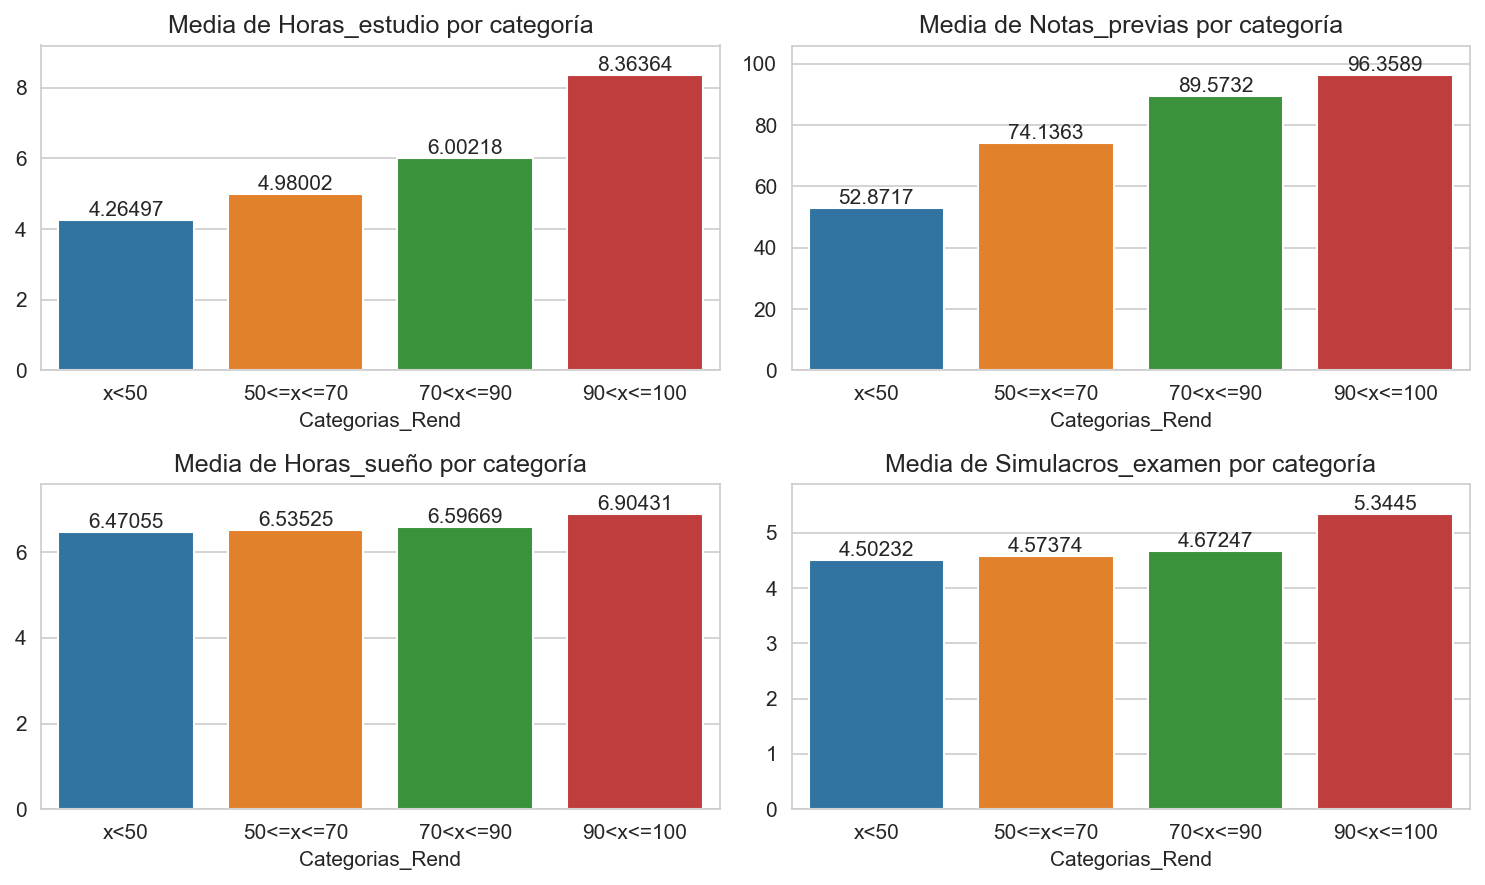

In [10]:
# Representamos media de cada categoría en cada num_feat
fig,axes = plt.subplots(ncols=2, nrows=2, figsize=(10, 6), dpi=150)

for index in range(len(num_feats)):
    # Medias de categorías en cada variable numérica
    feature = num_feats[index]
    means = df.groupby("Categorias_Rend")[feature].mean().sort_values()

    # Representación con gráfico de barras
    ax = axes[0][index] if index<2 else axes[1][index - 2]
    bar = sns.barplot(x=means.index, y=means.values, ax=ax)
    bar.bar_label(bar.containers[0])
    bar.set_ylim(0, means.values.max() + 0.1*means.values.max())
    bar.set_title(f"Media de {means.name} por categoría")

print("Aquí tenemos las medias de cada categoría en cada feature numérico.")
plt.tight_layout()

¿Qué hemos aprendido?:
- Las variables de horas de estudio y notas previas afectan mucho al rendimiento en el examen que estamos estudiando.
- Las variables de horas de sueño y de número de simulacros realizados tienen una menos conexión con las diferentes categorías de alumnos.

Número de alumnos que hacen act_extra por categoría:

Categorias_Rend  Act_extra
50<=x<=70        0            1754
                 1            1650
70<x<=90         1            1182
                 0            1114
90<x<=100        1             118
                 0              91
x<50             0            2093
                 1            1998
Name: Act_extra, dtype: int64


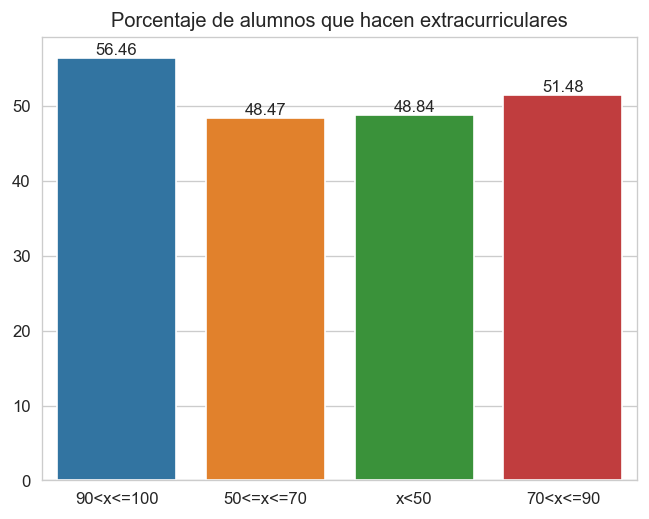

In [11]:
categorias = df["Categorias_Rend"].unique()
act_extra_por_cat = df.groupby("Categorias_Rend")["Act_extra"].value_counts()
print("Número de alumnos que hacen act_extra por categoría:\n")
print(act_extra_por_cat)

# Lista que guarda porcentages de 1=Sí por categoria
porcentajes = []

for cat in categorias:
    # Número de alumnos segun la cat que hacen extra
    value_counts_cat = act_extra_por_cat[cat]

    # Total de alumnos en dicha categoría
    total_en_cat = df["Categorias_Rend"].value_counts()[cat]

    # Porcentaje de alumnos que sí hacen extra en dicha cat.
    porcentaje_yes = round((value_counts_cat[1]/total_en_cat)*100, 2)
    porcentajes.append(porcentaje_yes)

# Representación con gráfico de barras.
plt.figure(dpi=120)
ax = sns.barplot(x=categorias, y=porcentajes)
ax.bar_label(ax.containers[0])
ax.set_title("Porcentaje de alumnos que hacen extracurriculares");

El porcentaje de alumnos que hacen actividades extracurriculares es más elevado que el resto en la categoría de *90<x<100*, aunque realmente están todos muy igualados en un 50% aproximadamente.


### Analizando la columna rendimiento.
Ya hemos analizado un poco los datos según la columna categórica, sin embargo, el objetivo es construir un modelo que nos ayude a predecir la *performance index* de un alumno según los features que nos ofrece el dataset. Ahora es momento de analizar esta columna numérica y de ver que *features* son los que más relación guardan con esta variable.

In [12]:
# Algunas estadísticas interesantes sobre la columna que queremos estudiar.
df.describe()["Rendimiento"]

count    10000.000000
mean        55.224800
std         19.212558
min         10.000000
25%         40.000000
50%         55.000000
75%         71.000000
max        100.000000
Name: Rendimiento, dtype: float64

Dos formas sencillas de medir la relación entre dos variables numéricas o cuantitativas
1. **Coeficiente de correlación de Pearson**. Puede tomar valores entre -1 y 1. Un valor de 1 significa una correlación positiva perfecta, lo que indica que cuando una variable aumenta, la otra también lo hace de manera proporcional. Un valor de -1 implica una correlación negativa perfecta, es decir, a medida que una variable aumenta la otra disminuye proporcionalmente. Un valor de 0 indica que no hay correlación lineal entre las variables.
2. **Un gráfico de dispersion**. Los valores de una variable se representan en el eje horizontal, mientras que los valores de la otra variable se representan en el eje vertical. Cada punto en el gráfico representa una *instancia* de nuestro conjunto de datos.

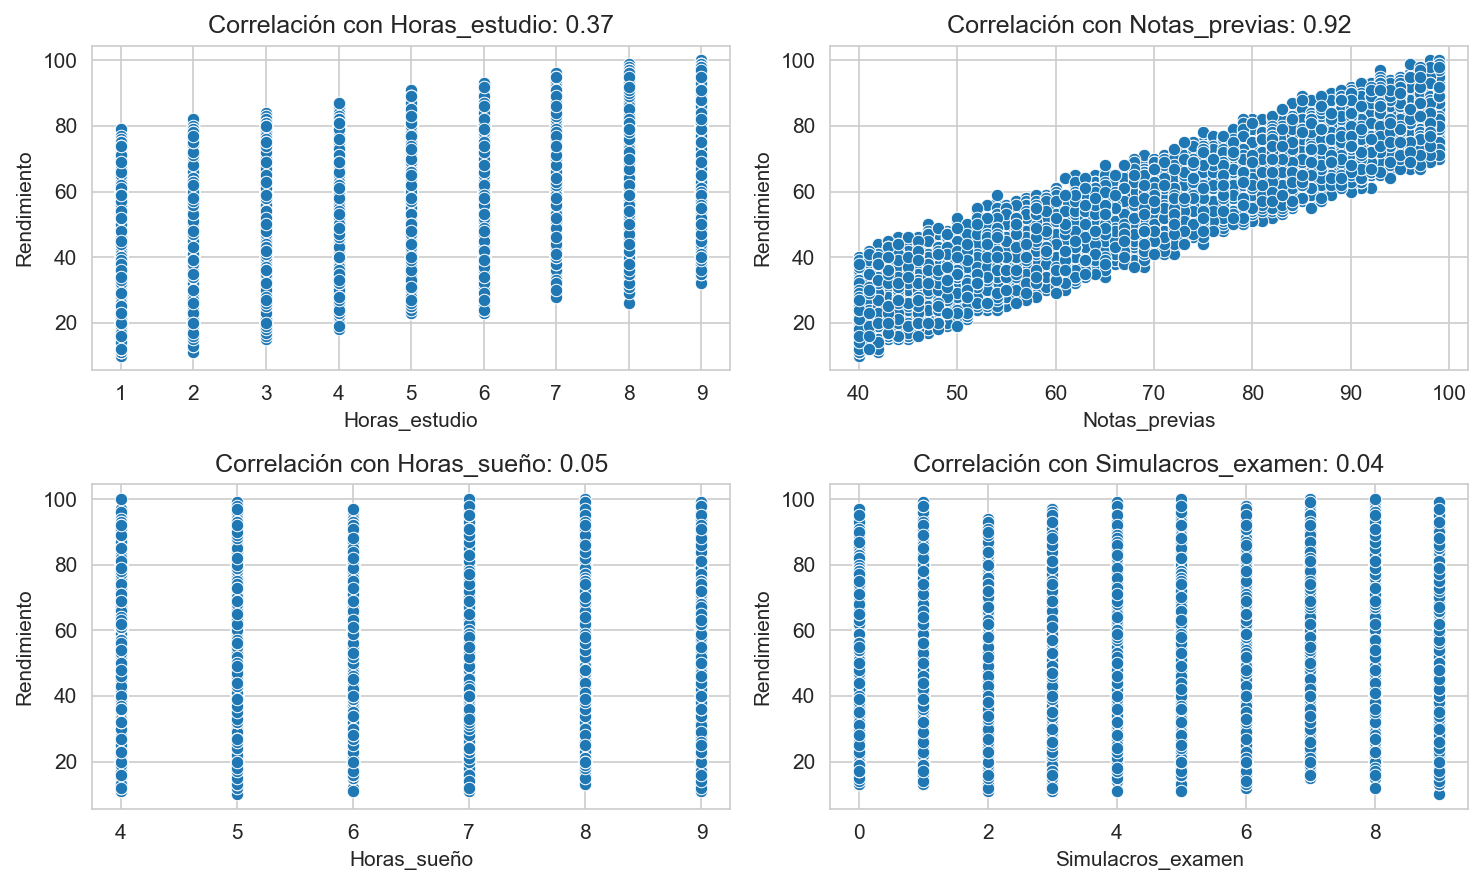

In [16]:
# Gráficos de dispersión y correlación de pearson:
fig,axes = plt.subplots(nrows=2, ncols=2, dpi=150, figsize=(10, 6))
for index in range(len(num_feats)):
    ax = axes[0][index] if index<2 else axes[1][index - 2]
    feature = num_feats[index]

    # Gráfico de dispersión entre variable rendimiento y el feature
    scat = sns.scatterplot(x=df[feature], y=df["Rendimiento"], ax=ax)

    # Calculamos correlación para poner en el gráfico
    correlacion = df.corr(numeric_only=True)['Rendimiento'][feature]
    scat.set_title(f"Correlación con {feature}: {correlacion:.2f}")

plt.tight_layout()

Las variables que más se correlacionan con el *Performance Index* son claramente las *Horas estudiadas* y las *Notas previas* obtenidas en otros exámenes. Serán por tanto estas variables las que más nos ayudarán a la hora de construir el modelo que nos sirva para predecir el **rendimiento** de un determinado alumno en función de sus características.

### Construyendo el modelo.
Hemos llegado a la parte más importante del proyecto. El **objetivo** es construir un *modelo* o una función $f:\mathbb{R}^4\to\mathbb{R}$. Esta función tomará como *input* un vector $x=(x_1,x_2,x_3,x_4)$ donde:
- $x_1$ = horas de estuido de un alumno
- $x_2$ = media de las notas en exámenes previos del alumno
- $x_3$ = 1 o 0 en función si el alumno hace actividades extracurriculares o no
- $x_4$ = número de simulacros de examen realizado por el alumno

Con este input, el modelo $f$, producira un número $y\in \mathbb{R}$ que será la predicción del *rendimiento* de dicho alumno. 

#### Cómo construimos el modelo
Para construir el modelo usaremos el algoritmo de la **regresión lineal**, es decir, nuestro modelo $f$ verificará que $$f(x)=w\cdot x+b$$ donde $w=(w_1,w_2,w_3,w_4)$ es el **vector de coeficientes** del modelo y $b\in \mathbb{R}$ es la **ordenada en el origen**

**Nota**: $w\cdot x=w_1x_1+w_2x_2+w_3x_3+w_4x_4$

El algoritmo de regresión lo que hará será encontrar el vector $w$ la ordenada $b$ que minimicen el **error cuadrático medio**, es decir, el algoritmo encontrará $w$ y $b$ de forma que: $$J(w,b)=\frac{1}{m}\sum_{i=1}^m (wx_i+b-y_i)^2$$ sea mínimo. Evidentemente $m$ es el número de instancias de nuestro conjunto de datos que denotaremos por $D$ y $(x_i,y_i)$ representa la instancia número $i$ de $D$.

#### 1. Dividir los datos
Dividiremos nuestro conjunto de datos $D$ en tres subconjuntos:
1. **X_train, y_train**: serán los datos de entrenamiento y estarán formados por un 60% de las instancias de nuestro conjunto de datos (tomo solo un 60% porque hay muchas instancias y porque tenemos *features* muy correlacionados con el target)
2. **X_cv, y_cv**: serán los datos de *cross-validation* y estarán formados por un 20% de las instancias de nuestro conjunto de datos. Nos servirán para hacer pruebas en ellos y escoger cual es el modelo final por el cual debemos optar
3. **X_test, y_test**: una vez ya tengamos el modelo listo mediremos su error final con unos datos que no ha visto nunca y que llamaremos subconjunto de testeo.

In [17]:
# "X" son los features, "y" es la target
X = df.drop(["Rendimiento", "Categorias_Rend"], axis=1)
y = np.array(df["Rendimiento"]).reshape(df.shape[0], 1)

# Importamos train_test_split de sklearn
from sklearn.model_selection import train_test_split

# 60% train data y 40% variables temporales X_, y_
X_train, X_, y_train, y_ = train_test_split(X, y, train_size=0.6, 
                                            random_state=101)

# Cross val y test set se llevan 50% cada una de las temporales
X_cv, X_test, y_cv, y_test = train_test_split(X_, y_, train_size=0.5, 
                                              random_state=101)

# Borramos variables temporales
del X_, y_

# Imprimimos los shapes de cada uno de los splits.
print(f"Shape train -> X_train: {X_train.shape} y_train: {y_train.shape}")
print(f"Shape cv -> X_cv: {X_cv.shape} y_cv: {y_cv.shape}")
print(f"Shape test -> X_test: {X_test.shape} y_test: {y_test.shape}")

Shape train -> X_train: (6000, 5) y_train: (6000, 1)
Shape cv -> X_cv: (2000, 5) y_cv: (2000, 1)
Shape test -> X_test: (2000, 5) y_test: (2000, 1)


#### 2. El modelo con regularización.
A la función $J(w,b)$ que vimos antes y que minimizará el algoritmo de regresión lineal le vamos a añadir un término
$$J(w,b)=\frac{1}{m}\sum_{i=1}^m (wx_i+b-y_i)^2 + \underbrace{\alpha \sum_{j=1}^n w_j^2}_{\text{Término añadido}}$$
Este término es el de la *regularización L2* o *RidgeRegression*. Añadimos este término para evitar que el modelo le de demasiado peso a variables que no guardan mucha relación con la target, es decir, para prevenir lo que se conoce como **overfitting**. Fíjate que el término añadio depende del parámetro $\alpha$. Lo que haremos será probar a entrenar al modelo con diferentes *alphas* y escogeremos el que mejor rendimiento tenga en el conjunto de datos de cross-validation. 

Antes de entrenar al modelo estandarizaremos los *features* para conseguir que el algoritmo funcione de una manera más eficiente

In [19]:
# Importamos de sklearn una clase para estandarizar los datos
from sklearn.preprocessing import MinMaxScaler
m_m_scaler = MinMaxScaler()

# Estandarizamos X_train con el método fit_transform
columnas = X_train.columns
X_train_s = pd.DataFrame(m_m_scaler.fit_transform(X_train), columns=columnas)
X_train_s.describe()

,Horas_estudio,Notas_previas,Act_extra,Horas_sueño,Simulacros_examen
count,6000.000000,6000.000000,6000.000000,6000.000000,6000.000000
mean,0.493500,0.500785,0.487667,0.505567,0.507093
std,0.324946,0.295153,0.499890,0.341411,0.319503
min,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.250000,0.237288,0.000000,0.200000,0.222222
50%,0.500000,0.491525,0.000000,0.600000,0.555556
75%,0.750000,0.762712,1.000000,0.800000,0.777778
max,1.000000,1.000000,1.000000,1.000000,1.000000


In [26]:
np.

array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9])

In [34]:
# Importamos el modelo Ridge de sklearn
from sklearn.linear_model import Ridge

# Importamos funciones de evaluación del modelo
from sklearn.metrics import mean_absolute_error, mean_squared_error

# Usaremos 200 valores de alpha entre 1 y 100
alphas = [0.001, 0.01, 0.5, 0.7, 1.0, 3.0, 5.0, 7.0, 10.0]

# Iniciamos listas de errores en CV
MSEs_cv = []
MAEs_cv = []

# Estandarizamos X_cv solo usando transform, no fit_transform
X_cv_s = pd.DataFrame(m_m_scaler.transform(X_cv), columns=X_cv.columns)

# Iteramos sobre los alphas
for alpha in alphas:

    # Creamos el modelo y lo adaptamos a nuestros datos de entrenamiento.
    ridge_model = Ridge(alpha=alpha)
    ridge_model.fit(X_train_s, y_train)

    # Predecimos los datos de cv
    y_cv_pred = ridge_model.predict(X_cv_s)

    # Obtenemos las evaluaciones del modelo y las guardamos.
    MAE_cv = mean_absolute_error(y_cv_pred, y_cv)
    MSE_cv = mean_squared_error(y_cv_pred, y_cv)
    MAEs_cv.append(MAE_cv)
    MSEs_cv.append(MSE_cv)

    # Imprimimos información en pantalla para cada loop
    print(f"Modelo con alpha={alpha:.2f} entrenado y evaluado.")

Modelo con alpha=0.00 entrenado y evaluado.
Modelo con alpha=0.01 entrenado y evaluado.
Modelo con alpha=0.50 entrenado y evaluado.
Modelo con alpha=0.70 entrenado y evaluado.
Modelo con alpha=1.00 entrenado y evaluado.
Modelo con alpha=3.00 entrenado y evaluado.
Modelo con alpha=5.00 entrenado y evaluado.
Modelo con alpha=7.00 entrenado y evaluado.
Modelo con alpha=10.00 entrenado y evaluado.


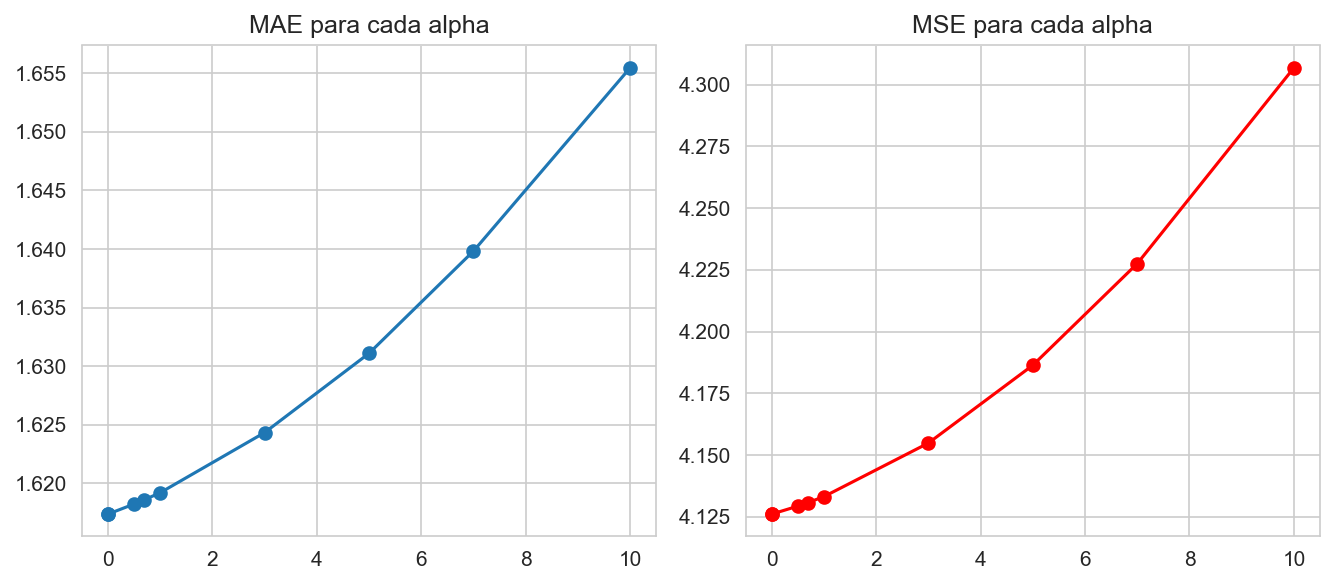

In [35]:
# Representamos errores en cross-validation para cada alpha
fig,axes = plt.subplots(ncols=2, dpi=150, figsize=(9, 4))
axes[0].plot(alphas, MAEs_cv, marker="o")
axes[0].set_title("MAE para cada alpha")
axes[1].plot(alphas, MSEs_cv, marker="o", c="r")
axes[1].set_title("MSE para cada alpha")
plt.tight_layout()

Vemos que en este caso la regularización no ha conseguido que el modelo generalizase mejor. Esto es debido a que tenemos muchas instancias a nuestra disposición y, por tanto, el modelo es capaz de "aprender" de forma muy exacta cuales son los coeficientes más adecuados para el modelo.